### **Library Load** 

In [ ]:
# install.packages('R.utils')

In [1]:
library(tidyverse)
library(data.table)
library(caret)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purr

### **UDF** 

In [2]:
data_load <- function(RData = FALSE, RData_scale = FALSE, RAW_file_path,RData_path, scaler){
  
  # pre load data
  if(RData){
    if(RData_scale){
      load(paste0(RData_path, "omics_data_t_std_scale.RData")) # preprocessing
    } else{
      load(paste0(RData_path, "omics_data_t.RData")) # preprocessing
    }
    return(omic_data)
  } else {
    # RNA Expression
    re_tpm <- fread(paste0(RAW_file_path, "tcga_RSEM_Hugo_norm_count.gz"), check.names = T) %>%
      select(sample, any_of(cnacer_selector("LIHC"))) %>%
      transpose_df() %>%
      select(-any_of(zero_col_remove(.)))
    
    if(scaler){
      preprocessParams <- preProcess(re_tpm[,2:length(re_tpm)], method=c("scale","center"))
      re_tpm <- predict(preprocessParams, re_tpm)
    }
    
    # miRNA
    mi <- fread(paste0(RAW_file_path, "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz"), check.names = T) %>%
      select(sample, any_of(cnacer_selector("LIHC"))) %>%
      transpose_df() %>%
      select(-any_of(zero_col_remove(.)))
    
    if(scaler){
      preprocessParams <- preProcess(mi[,2:length(mi)], method=c("scale","center"))
      mi <- predict(preprocessParams, mi)
    }
    
    # Methylation -> duplicate gene ->>>> average value
    mt_map <- fread(file = paste0(RAW_file_path, "probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy"), sep = "\t")  
    
    mt <- fread(paste0(RAW_file_path, "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz"), check.names = T) %>%
      select(sample, any_of(cnacer_selector("LIHC"))) %>%
      left_join(x = ., y = mt_map, by = c("sample" = "#id" )) %>% 
      select(-sample, -strand) %>% 
      select(gene, chrom, chromStart, chromEnd, everything()) %>% 
      filter(gene != ".", !is.na(chrom)) %>% 
      arrange(chrom, gene) %>%
      select(-chrom, -chromStart, -chromEnd) %>%
      group_by(gene) %>% 
      summarise_if(is.numeric, mean, na.rm = TRUE) %>%
      transpose_df() %>%
      select(-any_of(zero_col_remove(.))) %>%
      rename(sample = gene)
    
    if(scaler){
      preprocessParams <- preProcess(mt[,2:length(mt)], method=c("scale","center"))
      mt <- predict(preprocessParams, mt)
    }
    
    omic_data <- list(RNA = re_tpm, miRNA = mi, Methylation = mt)
    
    if(scaler){
      save(omic_data, file = paste0(RData_path, "omics_data_t_std_scale.RData"))
    } else{
      save(omic_data, file = paste0(RData_path, "omics_data_t.RData"))  
    }
    
    return(omic_data)
  }
}

cnacer_selector <- function(cancer_type){
  # phenotype
  #phe1 <- read_delim(file = paste0(file_path, "GDC-PANCAN.basic_phenotype.tsv")) %>% 
  phe1 <- read_delim(file = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/GDC-PANCAN.basic_phenotype.tsv.gz", delim = "\t", show_col_types = F) %>%
    filter(program == "TCGA") %>% 
    mutate(sample = str_remove(sample, pattern = "\\.")) %>% 
    mutate(sample = str_remove(sample, pattern = ".$")) %>%
    distinct(sample, .keep_all = TRUE) %>% 
    select(sample, sample_type, project_id)
  
  # phenotype2 - TCGA abb contained
  # phe2 <- read_delim(file = paste0(file_path, "TCGA_phenotype_denseDataOnlyDownload.tsv"))
  phe2 <- read_delim(file = "https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGA_phenotype_denseDataOnlyDownload.tsv.gz", delim = "\t", show_col_types = F)
  pr_phe <- left_join(x = phe2, y = phe1, by = "sample") %>% 
    filter(!is.na(project_id)) %>%
    mutate(sample = str_replace_all(sample, "\\-", "\\."))
  
  # cancer sample barcode with Primary Tumor
  if(cancer_type == "PAN" | cancer_type == "PANCAN"){
    sample_barcode <- pr_phe %>% pull(1)
  } else {
    sample_barcode <- pr_phe %>% filter(project_id == paste0("TCGA-", cancer_type), sample_type.y == "Primary Tumor") %>% pull(1)
  }
  
  return(sample_barcode)
}

# zero col remove
zero_col_remove <- function(df){
  N_zero <- as.integer(nrow(df) * 0.2) # 20% Feature remove
  col_names <- lapply(X = df, FUN = function(col){
    if(is.character(col)){ 
        return(NULL)}
    zero_col <- col[col == 0] %>% length()
      
    if(zero_col >= N_zero){
      return(TRUE)
    } else {
      return(NULL)
    }
  }) %>% bind_cols()
  
  return(colnames(col_names))
}

# impute
impute_DF <- function(df, chr_index){
 tmp <- impute::impute.knn(data = as.matrix(df[, -chr_index]))
 name_col <- df %>% select_at(chr_index)
 
 bind_cols(name_col, as_tibble(tmp$data)) %>% return()
}

# dataframe transpose
transpose_df <- function(df) {
  t_df <- data.table::transpose(df)
  colnames(t_df) <- rownames(df)
  rownames(t_df) <- colnames(df)
  t_df <- t_df %>%
    tibble::rownames_to_column(.data = .) %>%
    tibble::as_tibble(.)
    
  col_name <- t_df[1, ] %>% as.character()
  t_df <- t_df[-1, ]
  colnames(t_df) <- col_name
  
  # chr to numeric
  t_df %>% mutate_at(vars(-names(.)[1]), as.numeric) %>%
   return()
}

### **File PATH** 

In [3]:
RAW_file_path = "/home/jovyan/work/RAW_DATA/"
RDATA_file_path = "/home/jovyan/work/RData/"
MODEL_path = "/home/jovyan/work/models/"

### **Multi-Omics Data Load(RNA / miRNA ~ 20% zero column remove & MinMax Scaler or Standardization** 

* **Omics Filterd**

In [ ]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("impute")

In [4]:
omic_data <- data_load(RData = TRUE, RData_scale = TRUE, RAW_file_path = RAW_file_path,
                       RData_path = RDATA_file_path, scaler = TRUE)

In [5]:
omic_data_impute <- lapply(X = omic_data, FUN = function(d) {
  impute_DF(df = d, chr_index = 1) %>% return()
})

#### **Intersect for Multi-Omics**

In [8]:
# install.packages("ggvenn")
library(ggvenn)

Loading required package: grid



In [9]:
re_tpm_col <- omic_data[[1]] %>% pull(1) %>% .[2:length(.)]
mi_col <- omic_data[[2]] %>% pull(1) %>% .[2:length(.)]
mt_col <- omic_data[[3]] %>% pull(1) %>% .[2:length(.)]

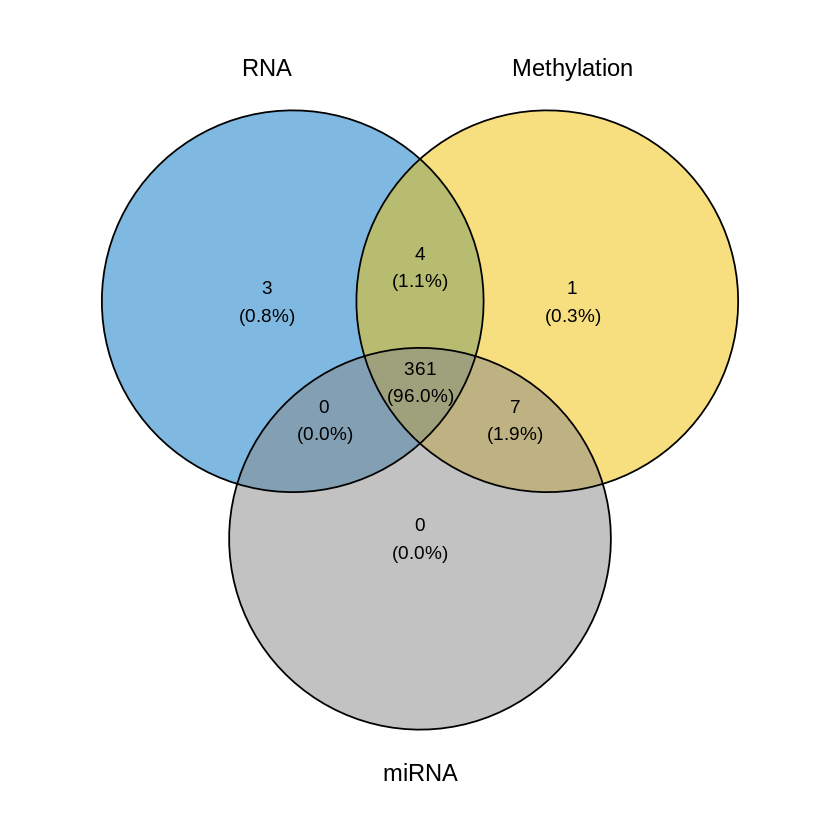

In [10]:
ggvenn(
  list(
    RNA = re_tpm_col, 
    Methylation = mt_col,
    # CNV = cnv_col,
    miRNA = mi_col
    # Somatic_Mutation = som_col,
    # Protein = pro_col
  ), 
  fill_color = c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#676FA3"),
  stroke_size = 0.5, set_name_size = 5
)

* Intersect ID

In [11]:
omic_3_intersect <- reduce(list(
  RNA = re_tpm_col, 
  Methylation = mt_col,
  miRNA = mi_col
  # CNV = cnv_col,
  # Somatic_Mutation = som_col
), intersect)

omic_3_intersect %>% length()

[1] 361

* **Join by Sample**

In [12]:
omics_join <- reduce(omic_data_impute, inner_join, by = "sample") # 5 ~ 10 min

In [13]:
omics_join %>% head()

sample,RP11-16E12.2.x,RP11-181G12.2,CPHL1P.x,TCOF1.x,NSRP1.x,RP5-1000K24.2,SPPL3.x,AF001548.5,OPA3.x,⋯,"ZWILCH,RPL4",ZWINT.y,ZXDA.y,ZXDB.y,ZXDC.y,ZYG11A.y,ZYG11B.y,ZYX.y,ZZEF1.y,ZZZ3.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA.BC.A10S.01,-0.81073716,-0.37591299,-0.02904014,-0.3254683,0.17985410,0.08554083,0.3250347,0.6523730,0.5613818,⋯,-1.1765110,-0.78863075,0.3907789,-0.3373604,0.04309263,1.30865300,1.0704220,-0.3950418,0.77730370,-0.7177834
TCGA.BC.A112.01,0.34094208,-0.25919348,-0.85767398,1.1536283,2.49012379,0.18727480,1.1125308,1.0719801,1.4692684,⋯,-0.8178471,-0.01187949,-0.8196469,-0.8907440,-0.48356884,1.51569960,0.9997589,0.8050173,0.55602028,-0.3405444
TCGA.ES.A2HS.01,-0.19955201,-1.21872121,-0.70542640,-0.2103389,-0.72134405,-1.72205785,-0.2253519,0.2730475,1.8904623,⋯,-1.1754889,-0.29215481,-0.7384532,-0.5657091,-0.94705665,-1.11822520,-0.4968413,-1.3796955,1.24893079,-0.1588746
TCGA.FV.A2QQ.01,0.91390203,-1.29407533,0.26472022,-0.7087318,-1.50819884,-0.23742592,-0.1739280,-0.6984087,1.4463438,⋯,-0.6858322,-0.72451802,-0.6343433,-0.7563874,-0.22686421,0.06675706,0.3649811,-0.7890706,0.86836035,-0.2489943
TCGA.FV.A4ZP.01,2.05945038,-0.53978718,0.45393288,3.2361770,-2.83762007,-3.03786876,0.1647384,1.7772993,0.7285858,⋯,1.0042877,-0.22424421,-0.4261157,-0.9479418,-0.83632094,-0.62687563,0.5251044,0.2692583,0.90257840,0.6093203
TCGA.HP.A5MZ.01,-0.05617268,-0.01959167,0.28660989,-0.7948534,0.01008397,0.77494850,-0.4116829,-0.2711455,-0.6439787,⋯,-0.5334458,-1.02012018,-0.6474658,-0.5478117,0.37678255,-0.37478334,1.5228076,-0.3995503,-0.08466183,-0.6176356


### **Auto-Encoer using H2O**

In [337]:
# install.packages("h2o", type="source", repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R")))
library(h2o)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:data.table’:

    hour, month, week, year


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




In [346]:
h2o.init(max_mem_size = "42g")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpqU5On2/file1d631291356e/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpqU5On2/file1d6329dc36fb/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 698 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.1 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_root_jvn968 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   42.00 GB 
    H2O cluster total cores:    32 
    H2O cluster allowed cores:  32 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:  

* **AutoEncoder using H2O**

In [347]:
features <- as.h2o(omics_join %>% select(-sample))

  |======================================================================| 100%


* **grid search**

In [344]:
# # Hyperparameter search grid
# hyper_grid <- list(hidden = list(
#   c(500, 100, 500),
#   c(300, 100, 300),
#   c(500, 250, 100, 250, 500)
# ))

# # Execute grid search
# ae_grid <- h2o.grid(
#   algorithm = 'deeplearning',
#   x = seq_along(features),
#   training_frame = features,
#   grid_id = 'autoencoder_grid',
#   autoencoder = TRUE,
#   activation = 'TanhWithDropout',
#   # hidden_dropout_ratios = 0.5, 
#   l1 = 0.001, # alpha-w
#   l2 = 0.0001, # alpha-a
#   hyper_params = hyper_grid,
#   sparse = FALSE,
#   ignore_const_cols = FALSE,
#   seed = 331
# )

# # Print grid details
# h2o.getGrid('autoencoder_grid', sort_by = 'mse', decreasing = FALSE)

  |                                                                      |   0%

In [348]:
# Train an autoencoder
ae <- h2o.deeplearning(
  x = seq_along(features),
  training_frame = features,
  autoencoder = TRUE,
  hidden = c(300, 100, 300),
  activation = 'TanhWithDropout',
  # hidden_dropout_ratios = 0.5, 
  l1 = 0.001, # alpha-w
  l2 = 0.0001, # alpha-a,
  epochs = 10,
  sparse = FALSE
)

# model save
model_path <- h2o.saveModel(object = ae, path = MODEL_path, force = TRUE, 
                            filename = paste0("h2o_AE_", format(Sys.time(), "%m_%d_%Y_%H%M")))

  |======================================================================| 100%


In [349]:
h2o_encoded <- h2o.deepfeatures(ae, features, layer = 3) %>% as_tibble()

  |======================================================================| 100%


In [350]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)?  y


### **Auto-Encoer using Keras**

* **install env**

In [14]:
# system("conda create -n r-reticulate")
# install.packages("keras")
# keras::install_keras(method = 'conda', envname = 'r-reticulate')

library(reticulate)
library(keras)

# use conda env
conda_list()[[1]][2] %>%
 use_condaenv(required = TRUE)

#### **Stacked AutoEncoder**

* preprocessing

In [15]:
k_clear_session()
sample_barcoder <- omics_join %>% select(sample)
input_feature <- omics_join %>% select(-sample) 

input_feature <- input_feature %>% as.matrix
input_size <- dim(input_feature)[2]
latent_size <- 100

# # train_test split
# index = createDataPartition(input_feature, p = 0.70, list = FALSE)
# train = iris[index, ]
# test = iris[-index, ]

Loaded Tensorflow version 2.7.0



* Encoder

In [16]:
enc_input <- layer_input(shape = input_size)
enc_output <- enc_input %>% 
  layer_dense(units = 1000, activation = "tanh") %>% 
  layer_dense(units = 500, activation = "tanh") %>%
  layer_dense(units=latent_size, activation = "tanh")

encoder <- keras_model(enc_input, enc_output)

* Decoder

In [17]:
dec_input <- layer_input(shape = latent_size)
dec_output <- dec_input %>% 
  layer_dense(units = 500, activation = "tanh") %>% 
  layer_dense(units = 1000, activation = "tanh") %>%
  layer_dense(units = input_size, activation = "sigmoid")

decoder <- keras_model(dec_input, dec_output)

* End-to-End

In [18]:
aen_input <- layer_input(shape = input_size)
aen_output <- aen_input %>% 
  encoder() %>% 
  decoder()
   
aen <- keras_model(aen_input, aen_output)

* **Compile & Fit**

In [19]:
# end-toend AE
aen %>% 
 compile(optimizer="adam", loss="binary_crossentropy")

# history_encode <- encoder %>% fit(input_feature,input_feature, epochs=30, batch_size=32, verbose = 2, validation_split = 0.3)
history <- aen %>% fit(input_feature,input_feature, epochs=30, batch_size=32, verbose = 2, validation_split = 0.2)

In [20]:
save_model_hdf5(aen, paste0(MODEL_path, "keras_AE_", format(Sys.time(), "%m_%d_%Y_%H%M.h5")))

In [21]:
encoded <- encoder %>% predict(input_feature)

In [22]:
head(encoded)

0.9472083,0.9990348,-0.8269970,-0.9998603,-0.8676419,0.9960127,-0.2831456,0.9982328,0.6720848,0.9968382,⋯,0.9285118,0.9754194,0.9174835,0.8298175,-0.1232017,-0.95239866,-0.9870118,0.3719567,0.7179168,0.9187154
0.9976313,0.9999093,-0.9999666,0.5351974,-0.9989920,0.9999259,-0.9991561,-0.2368858,0.9977757,-0.2985360,⋯,0.9996160,-0.7215216,0.9995105,-0.8603261,-0.9973978,-0.97207463,-0.9960552,0.3084999,0.7930134,-0.9915019
-0.6386059,0.8335218,0.9999242,-0.9999544,0.6100909,-0.2906902,0.9997779,0.9996025,-0.9913040,0.9999453,⋯,-0.9591348,0.9807109,-0.7460248,0.9090046,0.2462458,-0.06429611,-0.8904874,0.8418232,-0.9463712,0.9999548
-0.0161476,0.9947038,0.9505563,-0.9993805,0.6559429,0.9836671,0.9606310,0.9991882,-0.9350290,0.9993998,⋯,-0.9073631,0.9943751,-0.6700301,-0.4053802,0.9980904,0.75935608,-0.7191725,0.1054749,0.4857392,0.9909081
0.1386282,0.9916458,-0.2381676,0.9053009,0.3638137,0.9959424,0.9941433,0.8979182,0.6819255,0.9844388,⋯,0.2349995,0.3672293,0.5149599,0.3054442,-0.9385103,-0.42235848,-0.9263602,0.6188243,0.5738867,0.7623810
0.9980138,0.9998367,-0.9998847,0.4004538,-0.9888522,0.9999964,-0.9993195,-0.2097106,0.9988117,-0.8403741,⋯,0.9998055,0.6408883,0.9979005,-0.9754520,-0.7761939,-0.90735036,-0.9934289,-0.9580672,0.9916122,-0.9974636


#### **Variation AutoEncoder**

In [378]:
if (tensorflow::tf$executing_eagerly())
  tensorflow::tf$compat$v1$disable_eager_execution()

In [23]:
# Parameters --------------------------------------------------------------
k_clear_session()
batch_size <- 32
original_dim <- dim(input_feature)[2]
latent_dim <- 100L
intermediate_dim <- 256L
epochs <- 30L
epsilon_std <- 1.0

In [24]:
# Model definition --------------------------------------------------------
x <- layer_input(shape = c(original_dim))
h <- layer_dense(x, intermediate_dim, activation = "relu")
z_mean <- layer_dense(h, latent_dim)
z_log_var <- layer_dense(h, latent_dim)

In [25]:
sampling <- function(arg){
  z_mean <- arg[, 1:(latent_dim)]
  z_log_var <- arg[, (latent_dim + 1):(2 * latent_dim)]
  
  epsilon <- k_random_normal(
    shape = c(k_shape(z_mean)[[1]]), 
    mean=0.,
    stddev=epsilon_std
  )
  
  z_mean + k_exp(z_log_var/2)*epsilon
}

In [26]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z <- layer_concatenate(list(z_mean, z_log_var)) %>% 
  layer_lambda(sampling)

# we instantiate these layers separately so as to reuse them later
decoder_h <- layer_dense(units = intermediate_dim, activation = "relu")
decoder_mean <- layer_dense(units = original_dim, activation = "sigmoid")
h_decoded <- decoder_h(z)
x_decoded_mean <- decoder_mean(h_decoded)

# end-to-end autoencoder
vae <- keras_model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder_vae <- keras_model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input <- layer_input(shape = latent_dim)
h_decoded_2 <- decoder_h(decoder_input)
x_decoded_mean_2 <- decoder_mean(h_decoded_2)
generator <- keras_model(decoder_input, x_decoded_mean_2)

In [27]:
vae_loss <- function(input, x_decoded_mean){
  xent_loss=(input_size/1.0)*loss_binary_crossentropy(input, x_decoded_mean)
  kl_loss=-0.5*k_mean(1+z_log_var-k_square(z_mean)-k_exp(z_log_var), axis=-1)
  xent_loss + kl_loss
}

vae %>% compile(optimizer = "rmsprop", loss = vae_loss)

In [28]:
summary(vae)

Model: "model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_1 (InputLayer)     [(None, 58379)]   0        []                         
                                                                                
 dense (Dense)            (None, 256)       1494528  ['input_1[0][0]']          
                                            0                                   
                                                                                
 dense_1 (Dense)          (None, 100)       25700    ['dense[0][0]']            
                                                                                
 dense_2 (Dense)          (None, 100)       25700    ['dense[0][0]']            
                                                                                
 concatenate (Concatenate  (None, 200)      0        ['dense_1[0][0]',          
 )           

In [30]:
# Model training ----------------------------------------------------------
vae %>% fit(
  input_feature, input_feature, 
  # shuffle = TRUE, 
  epochs = epochs, 
  batch_size = batch_size
)

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): TypeError: in user code:

    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/engine/training.py", line 810, in train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 240, in __call__
        total_loss_metric_value, sample_weight=batch_dim)
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/utils/metrics_utils.py", line 73, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/metrics.py", line 177, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/metrics.py", line 452, in update_state  **
        sample_weight, values)
    File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/engine/keras_tensor.py", line 256, in __array__
        f'You are passing {self}, an intermediate Keras symbolic input/output, '

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_11'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


Detailed traceback:
  File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/conda/envs/r-reticulate/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py", line 1129, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)



In [372]:
encoded_vae <- encoder_vae %>% predict(input_feature)

In [374]:
input_feature

RP11-16E12.2.x,RP11-181G12.2,CPHL1P.x,TCOF1.x,NSRP1.x,RP5-1000K24.2,SPPL3.x,AF001548.5,OPA3.x,OPA1.x,⋯,"ZWILCH,RPL4",ZWINT.y,ZXDA.y,ZXDB.y,ZXDC.y,ZYG11A.y,ZYG11B.y,ZYX.y,ZZEF1.y,ZZZ3.y
-0.81073716,-0.375912986,-0.02904014,-0.32546830,0.179854096,0.08554083,0.3250347,0.6523730,0.56138181,-0.59108613,⋯,-1.17651100,-0.78863075,0.39077887,-0.3373604,0.04309263,1.30865300,1.0704220,-0.395041832,0.77730370,-0.71778336
0.34094208,-0.259193477,-0.85767398,1.15362828,2.490123789,0.18727480,1.1125308,1.0719801,1.46926842,-0.01146627,⋯,-0.81784712,-0.01187949,-0.81964695,-0.8907440,-0.48356884,1.51569960,0.9997589,0.805017320,0.55602028,-0.34054442
-0.19955201,-1.218721213,-0.70542640,-0.21033894,-0.721344052,-1.72205785,-0.2253519,0.2730475,1.89046231,-1.63337329,⋯,-1.17548888,-0.29215481,-0.73845318,-0.5657091,-0.94705665,-1.11822520,-0.4968413,-1.379695465,1.24893079,-0.15887455
0.91390203,-1.294075327,0.26472022,-0.70873182,-1.508198836,-0.23742592,-0.1739280,-0.6984087,1.44634383,-0.16499029,⋯,-0.68583222,-0.72451802,-0.63434327,-0.7563874,-0.22686421,0.06675706,0.3649811,-0.789070634,0.86836035,-0.24899427
2.05945038,-0.539787176,0.45393288,3.23617702,-2.837620067,-3.03786876,0.1647384,1.7772993,0.72858577,-2.99051805,⋯,1.00428774,-0.22424421,-0.42611572,-0.9479418,-0.83632094,-0.62687563,0.5251044,0.269258274,0.90257840,0.60932033
-0.05617268,-0.019591670,0.28660989,-0.79485338,0.010083966,0.77494850,-0.4116829,-0.2711455,-0.64397868,-0.14422836,⋯,-0.53344582,-1.02012018,-0.64746578,-0.5478117,0.37678255,-0.37478334,1.5228076,-0.399550302,-0.08466183,-0.61763561
-0.85997010,-0.291968315,-1.26200286,2.35106375,-0.650315679,-0.03142014,-0.1059365,-1.1901398,-0.05903770,-1.07680109,⋯,-0.09273919,-0.49164952,-0.46075033,-0.2699908,0.32994348,1.52388334,-0.1466947,-0.004249195,-0.24618828,-0.02139952
-0.10350133,-1.224417125,0.36665422,0.03194372,0.277774714,-0.44663158,0.1406401,-0.7446933,-2.00908354,0.90853501,⋯,0.15670913,-0.72387897,-0.12191940,-0.4004943,0.89285259,-0.08695926,0.9262769,1.466088903,1.03459670,1.54389687
-0.28008966,-1.995326135,-1.26200286,-0.63388271,0.196482125,0.55901207,-1.0337188,-1.0559839,-0.51461848,-0.40270491,⋯,-0.32184608,0.73370302,-0.64005385,0.1293331,0.99970263,-0.79250098,1.7598522,0.914466156,0.64280541,-0.50116597
-0.73814180,-1.770010795,0.51918184,0.66049589,0.215162998,0.88804756,-1.1440973,-0.5131830,-0.04702958,1.35901183,⋯,-0.73823101,-0.11242980,-0.62217538,-1.0163842,0.84791496,2.24376849,1.4569082,1.024610367,0.82679889,-0.92882510


### **K-Mean Clustering**

In [323]:
# install.packages("NbClust")
library(NbClust)

#### Keras AE

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


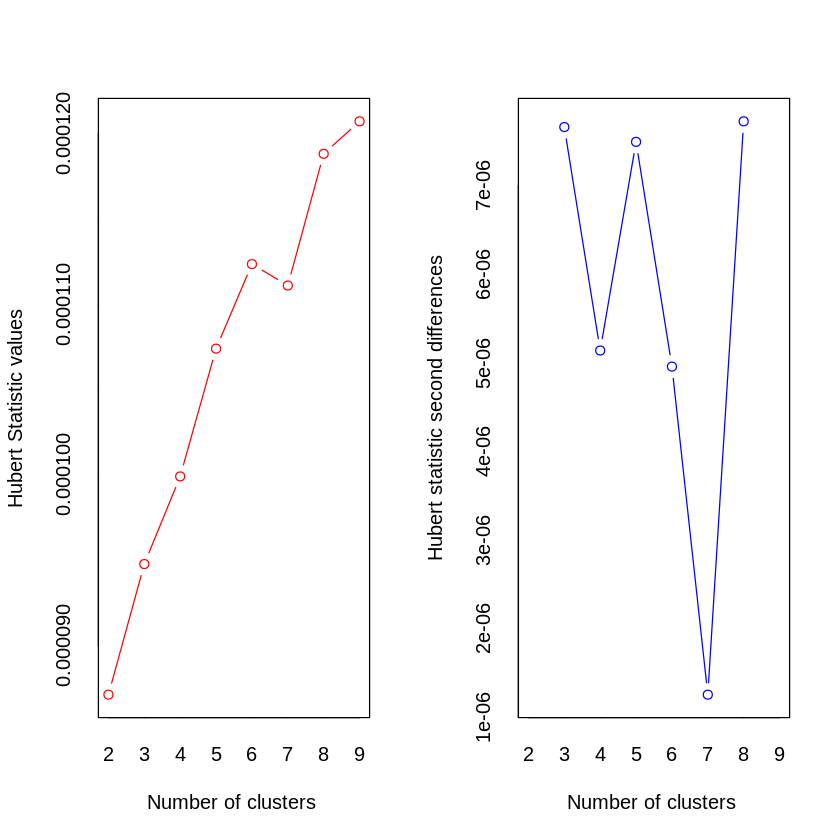

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 7 proposed 2 as the best number of clusters 
* 6 proposed 3 as the best number of clusters 
* 2 proposed 4 as the best number of clusters 
* 3 proposed 6 as the best number of clusters 
* 5 proposed 9 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
******************************************************************* 


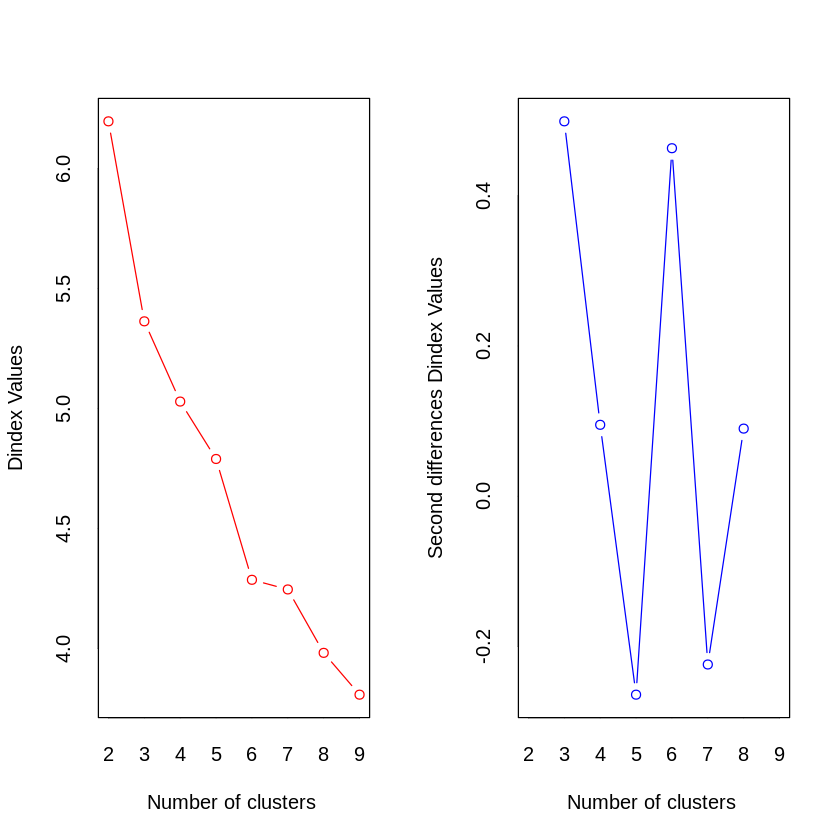

In [325]:
nc <- NbClust(encoded,min.nc=2,max.nc=9,method="kmeans")

#### H2O AE

In [352]:
head(h2o_encoded)

DF.L3.C1,DF.L3.C2,DF.L3.C3,DF.L3.C4,DF.L3.C5,DF.L3.C6,DF.L3.C7,DF.L3.C8,DF.L3.C9,DF.L3.C10,⋯,DF.L3.C291,DF.L3.C292,DF.L3.C293,DF.L3.C294,DF.L3.C295,DF.L3.C296,DF.L3.C297,DF.L3.C298,DF.L3.C299,DF.L3.C300
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.500000,0.5000000,-0.5000000,0.5,0.5,0.4992280,0.5000000,-0.4999999,0.1547659,0.4999997,⋯,-0.4999999,0.5,-0.5000000,0.5000000,-0.5000000,-0.5000000,-0.2094039,-0.5,0.5000000,-0.4999999
0.496475,0.4999862,-0.4979228,0.5,0.5,0.4958912,0.5000000,-0.4999999,-0.3791959,0.4999974,⋯,0.3369876,0.5,0.4054751,0.5000000,-0.5000000,0.4999997,0.5000000,-0.5,0.4999594,0.5000000
-0.500000,0.4542778,-0.5000000,0.5,0.5,0.4999990,0.5000000,-0.5000000,0.4902818,0.5000000,⋯,-0.4999978,0.5,-0.5000000,-0.5000000,-0.4999984,-0.5000000,-0.2008241,-0.5,0.5000000,-0.5000000
-0.500000,0.4985224,-0.5000000,0.5,0.5,0.4901588,0.3812349,0.4999998,0.4999998,0.4999997,⋯,-0.5000000,0.5,-0.5000000,0.4999926,-0.5000000,0.4988499,-0.3902649,-0.5,0.4892667,-0.4999849
-0.500000,0.5000000,0.4503764,0.5,0.5,0.4171158,0.4998928,-0.4716596,0.5000000,0.5000000,⋯,-0.5000000,0.5,-0.5000000,0.4931425,-0.4943314,0.5000000,0.4999502,-0.5,-0.5000000,-0.5000000
-0.500000,0.5000000,-0.5000000,0.5,0.5,0.4997805,0.5000000,-0.4975839,-0.4982206,0.4115438,⋯,-0.4949683,0.5,-0.5000000,0.5000000,-0.5000000,-0.4999983,0.5000000,-0.5,0.4971855,0.4999986


*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


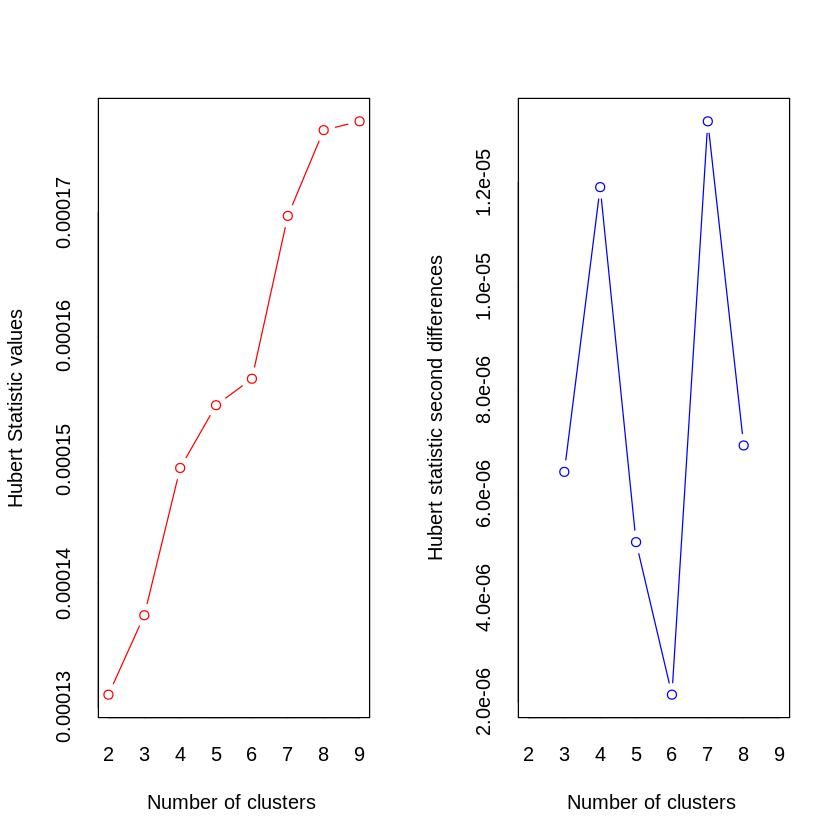

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 13 proposed 2 as the best number of clusters 
* 3 proposed 3 as the best number of clusters 
* 4 proposed 4 as the best number of clusters 
* 3 proposed 8 as the best number of clusters 
* 1 proposed 9 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
******************************************************************* 


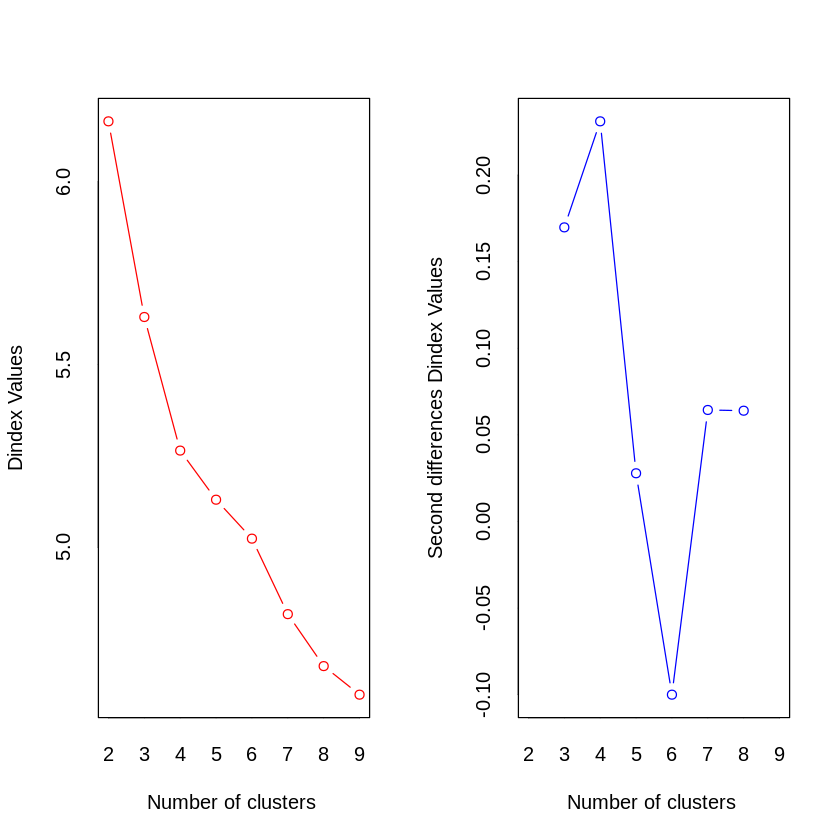

In [351]:
nho2 <- NbClust(h2o_encoded,min.nc=2,max.nc=9,method="kmeans")